In [ ]:
!pip install datasets pandas sentence-transformers

In [ ]:
import pandas as pd
from datasets import load_dataset

def assign_priority(ticket_text):
    """Assigns a priority level to a ticket based on keywords."""
    # Ensure ticket_text is a string, handle potential None values
    ticket_text = str(ticket_text).lower()
    high_priority_keywords = ['urgent', 'down', 'cannot access', 'payment failed', 'critical', 'error', 'blocker']
    low_priority_keywords = ['how to', 'question', 'inquiry', 'feature request', 'feedback', 'suggestion']

    if any(keyword in ticket_text for keyword in high_priority_keywords):
        return 'High'
    elif any(keyword in ticket_text for keyword in low_priority_keywords):
        return 'Low'
    else:
        return 'Medium'

# 1. Load the dataset from Hugging Face
print("Step 1: Loading dataset...")
dataset = load_dataset("Tobi-Bueck/customer-support-tickets")
df = pd.DataFrame(dataset['train'])

# Work with a smaller sample to keep it fast
df_sample = df.sample(n=1000, random_state=42).copy() # Added .copy() to avoid SettingWithCopyWarning

# Print columns to help diagnose
print("DataFrame columns:", df_sample.columns)

# Create a combined text column from 'subject' and 'body'
print("Combining ticket subject and description...")
df_sample['text'] = df_sample['subject'].fillna('') + ' ' + df_sample['body'].fillna('')

# 2. Apply the tagging function to create a 'priority' column
print("Step 2: Tagging tickets by priority...")
df_sample['priority'] = df_sample['text'].apply(assign_priority)

print("\n✅ Success! Here's a preview of your tagged data:")
print(df_sample[['text', 'priority']].head())

Step 1: Loading dataset...
DataFrame columns: Index(['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language',
       'version', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6',
       'tag_7', 'tag_8'],
      dtype='object')
Combining ticket subject and description...
Step 2: Tagging tickets by priority...

✅ Success! Here's a preview of your tagged data:
                                                    text priority
59903  Sicherheitsverstoß im Krankenhaus-System Es wu...   Medium
24200  Trouble with WhatsApp Desktop Experienced tech...   Medium
35048  Sporadische Scannerfehler am Point of Sale Seh...   Medium
31808  Markt-Alarm-Verzögerungen in der Handelsplattf...   Medium
29641  Probleme bei der Buchung von Proberäumen Hallo...   Medium


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("\nStep 3: Loading the AI model (this may take a moment)...")
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Step 4: Converting text to numbers (embeddings)...")
# This line takes all the text from your 'text' column and encodes it
ticket_embeddings = model.encode(df_sample['text'].tolist(), show_progress_bar=True)

print(f"\n✅ Success! Embeddings generated.")
print(f"The result is a big table of numbers with shape: {ticket_embeddings.shape}")


Step 3: Loading the AI model (this may take a moment)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Step 4: Converting text to numbers (embeddings)...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


✅ Success! Embeddings generated.
The result is a big table of numbers with shape: (1000, 384)



Step 5: Creating a visualization...

✅ All Done! A plot has been saved as 'ticket_visualization.png'.


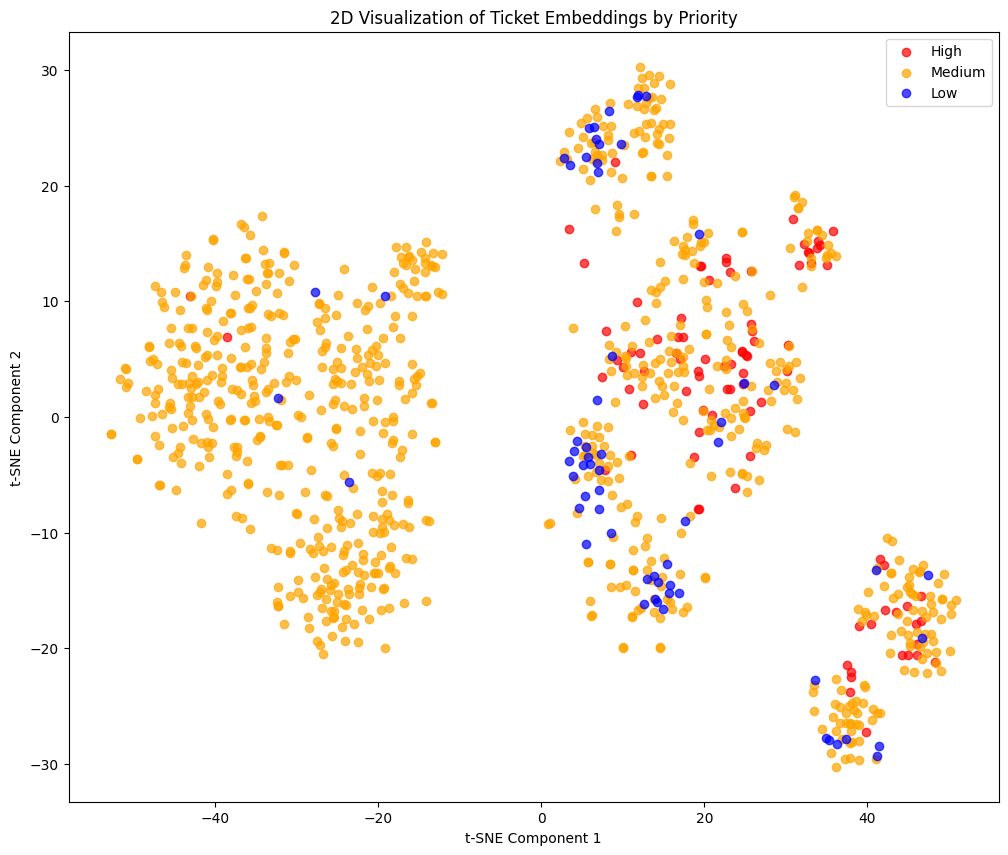

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

print("\nStep 5: Creating a visualization...")

# Use t-SNE to reduce the 384 dimensions to 2 for plotting
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(ticket_embeddings)

# Create a DataFrame for easy plotting
df_plot = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_plot['priority'] = df_sample['priority'].values

# Create the scatter plot
plt.figure(figsize=(12, 10))
colors = {'High': 'red', 'Medium': 'orange', 'Low': 'blue'}

for priority_level, color in colors.items():
    subset = df_plot[df_plot['priority'] == priority_level]
    plt.scatter(subset['x'], subset['y'], c=color, label=priority_level, alpha=0.7)

plt.title('2D Visualization of Ticket Embeddings by Priority')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.savefig('ticket_visualization.png') # This saves the plot as an image file

print("\n✅ All Done! A plot has been saved as 'ticket_visualization.png'.")